In [28]:
from autoencoders import *
from pdb_utils import *

import pickle
import numpy as np
import pandas as pd
import random

import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from functools import partial
import sys

from Bio import PDB
import numpy as np
import os
import cv2

import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
import time
from sklearn.model_selection import StratifiedShuffleSplit

In [4]:
def nice_time(start,end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Runtime: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

In [ ]:
with open('../Labels/PDBs-fold-groups.pkl', 'rb') as f:
    fold_dict = pickle.load(f)
with open('../Labels/PDBs-family-labels.pkl', 'rb') as f:
    label_dict = pickle.load(f)
with open('../Labels/SCOPTest-family-labels.pkl', 'rb') as f:
    test_label_dict = pickle.load(f)

In [10]:
# FoldGroupProteins_10-20_64x64.pkl includes proteins of folds that have at least 10 and at most 20 proteins in it.
# These protein structures resized to=(64,64) and removeSymmetry=True

with open("FoldGroupProteins_10-20_64x64.pkl", "r") as f:
    proteinmatrixdict = pickle.load(f)

In [13]:
labels, features = list(proteinmatrixdict.keys()), list(proteinmatrixdict.values())
input_size = len(features[0])
print("Number of pdbs: %d"%len(features))
print("Input size: %d"%input_size)

Number of pdbs: 2765
Input size: 2016


In [14]:
print("\nLinear Autoencoder - 100 epochs")
s_time = time.time()
new_features, loss = LinearAutoencoder(features, input_size, 50, 100, learning_rate=0.0001)
end = time.time()
nice_time(s_time,end)


Linear Autoencoder - 100 epochs
Runtime: 00:04:04.20


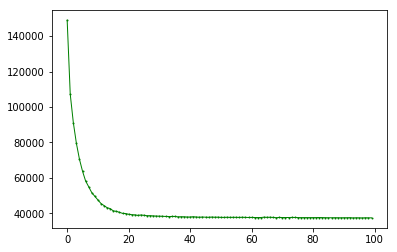

In [15]:
# LOSS GRAPH
fig, ax = plt.subplots()
ax.plot(range(0,len(loss)), loss, 'go-', linewidth=1, markersize=1)
fig.savefig("loss_figure.png")

In [32]:
def PdbClassifier(X,labels,label_dict,classifier,clf_level="family"):
    print("%s Level Classification")% clf_level.upper()
    # Encoding labels
    y = []
    for pdb in labels:
        if clf_level == "family":
            y.append(label_dict[pdb])
        elif clf_level == "superfamily":
            y.append(".".join(label_dict[pdb].split(".")[:3]))
        elif clf_level == "fold":
            y.append(".".join(label_dict[pdb].split(".")[:2]))
        elif clf_level == "class":
            y.append(label_dict[pdb].split(".")[0])
        else:
            print("Error: Not a valid classification level.")            
    uniques = list(set(y))
    print("Number of labels: %d"%len(uniques))
    group2id = dict(zip(uniques, range(len(uniques))))
    y = np.array(list(map(lambda x: group2id[x], y)))
    
    # Stratified Cross Validation
    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
    C = 1
    acc, prec, rec = 0,0,0
    s_time = time.time()
    for train_index, test_index in sss.split(X, y):
        print("\nStratified Cross Validation - %d"%C)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        print("Training...")
        # Fitting Random Forest Classification to the Training set
        classifier = classifier
        classifier.fit(X_train, y_train)
        
        # Print train/test accuracy
        y_pred_train = classifier.predict(X_train)
        print "Train accuracy: ",accuracy_score(y_train, y_pred_train)
        y_pred_test = classifier.predict(X_test)
        print "Test accuracy: ",accuracy_score(y_test, y_pred_test)
        
        acc+=accuracy_score(y_test, y_pred_test)
        prec+=precision_score(y_test, y_pred_test, average='weighted')
        rec+=recall_score(y_test, y_pred_test, average='weighted')
        C+=1
    end = time.time()
    nice_time(s_time,end)

    print "\naverage accuracy_score: ", acc/10
    print "average precision_score: ", prec/10
    print "average recall_score: ", rec/10

In [26]:
clf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)

In [37]:
X = np.array(new_features)
PdbClassifier(X,labels,label_dict,clf,clf_level="family")

FAMILY Level Classification
Number of labels: 200

Stratified Cross Validation - 1
Training...
Train accuracy:  1.0
Test accuracy:  0.6763110307414105

Stratified Cross Validation - 2
Training...
Train accuracy:  1.0
Test accuracy:  0.6799276672694394

Stratified Cross Validation - 3
Training...
Train accuracy:  1.0
Test accuracy:  0.6817359855334539

Stratified Cross Validation - 4
Training...
Train accuracy:  1.0
Test accuracy:  0.6817359855334539

Stratified Cross Validation - 5
Training...
Train accuracy:  1.0
Test accuracy:  0.6871609403254972

Stratified Cross Validation - 6
Training...
Train accuracy:  1.0
Test accuracy:  0.6998191681735986

Stratified Cross Validation - 7
Training...
Train accuracy:  1.0
Test accuracy:  0.6889692585895117

Stratified Cross Validation - 8
Training...
Train accuracy:  1.0
Test accuracy:  0.6907775768535263

Stratified Cross Validation - 9
Training...
Train accuracy:  1.0
Test accuracy:  0.6799276672694394

Stratified Cross Validation - 10
Trainin

# Testing with all parameters

In [ ]:
# SCOPTest
test_structures = []
for pdb in os.listdir("SCOP_Test/"):
    pdb_path = os.path.join("SCOP_Test", pdb)
    parser = PDB.PDBParser()
    structure = parser.get_structure(pdb, pdb_path)
    test_structures.append(structure)

print(len(test_structures))

# Selected folds from PDBs

selected_folds = list(filter(lambda x: x[1]>2, map(lambda x: (x[0],len(x[1])), fold_dict.items())))
len(selected_folds)

structures = []

for fold,pdb_list in selected_folds:
    for pdb in pdb_list[:5]:
        pdb_path = os.path.join("PDBs", pdb+".pdb")
        parser = PDB.PDBParser()
        structure = parser.get_structure(pdb, pdb_path)
        structures.append(structure)
        
results = {}
for strategy in ["strategy1","strategy2","strategy3"]:
    results[strategy] = []
    for filter_size in [32,64,96,128,256]:
        
        structures = []
        for fold,pdb_list in selected_folds:
            for pdb in pdb_list[:5]:
                pdb_path = os.path.join("PDBs", pdb+".pdb")
                parser = PDB.PDBParser()
                structure = parser.get_structure(pdb, pdb_path)
                sstructures.append(structure)
        
        if strategy == "strategy1":
            # Resize
            train_matrix = DistanceMatrixDict(structures, resize_strategy="strategy1", resize_to=(filter_size,filter_size),removeSymmetry=True)
            test_matrix = DistanceMatrixDict(test_structures, resize_strategy="strategy1", resize_to=(filter_size,filter_size),removeSymmetry=True)
            
        elif strategy == "strategy2":
            train_matrix = DistanceMatrixDict(structures, resize_strategy="strategy2", resize_to=(filter_size,filter_size),sample_size=60)
            test_matrix = DistanceMatrixDict(test_structures, resize_strategy="strategy2", resize_to=(filter_size,filter_size),sample_size=60)

        elif strategy == "strategy3":
            train_matrix = DistanceMatrixDict(structures, resize_strategy="strategy3", resize_to=(filter_size,filter_size))
            test_matrix = DistanceMatrixDict(test_structures, resize_strategy="strategy3", resize_to=(filter_size,filter_size))

        for encoding_size in [50,100,200,500]:
            train_pdb_names, train_features = list(train_matrix.keys()), list(train_matrix.values())
            test_pdb_names, test_features = list(test_matrix.keys()), list(test_matrix.values())
            input_size = len(train_features[0])
            
            # AutoEncoder
            autoencoder = LinearAutoEncoder(input_size, encoding_size, n_iteration=100, learning_rate = 0.0001,model_path = "models/autoencoder.ckpt")
            autoencoder.train(train_features)
            
            # Embedding vectors of train and test set
            new_train_features = autoencoder.encode(train_features)
            new_test_features = autoencoder.encode(test_features)      
            
            # Prepare train X and y
            train_feature_dict = {}
            for i in enumerate(train_pdb_names):
                if "sample" in i[1]:
                    pdb = i[1].split("sample")[0]
                else:
                    pdb = i[1]
                train_feature_dict.setdefault(pdb,[])
                train_feature_dict[pdb].append(new_train_features[i[0]])
                
            # Preparing test X and y
            test_feature_dict = {}
            for i in enumerate(test_pdb_names):
                if "sample" in i[1]:
                    pdb = i[1].split("sample")[0]
                else:
                    pdb = i[1]
                test_feature_dict.setdefault(pdb,[])
                test_feature_dict[pdb].append(new_test_features[i[0]])

            X_train = []
            y_train = []
            
            for pdb,vector in train_feature_dict.items():
                X_train.append(np.average(vector,axis=0))
                y_train.append(".".join(label_dict[pdb].split(".")[:2]))
                
            X_test = []
            y_test = []
            
            for pdb,vector in test_feature_dict.items():
                X_test.append(np.average(vector,axis=0))
                y_test.append(".".join(test_label_dict[pdb.split(".")[0]].split(".")[:2]))
                
                
            uniques = list(set(y_train).union(set(y_test)))
            group2id = dict(zip(uniques, range(len(uniques))))

            X_train = np.array(X_train)
            y_train = np.array(list(map(lambda x: group2id[x], y_train)))
            X_test = np.array(X_test)
            y_test = np.array(list(map(lambda x: group2id[x], y_test)))


            sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.40, random_state=42)
            for a, b in sss1.split(X_train, y_train):
                X_train_, y_train_ = X_train[a], y_train[a]
                X_validation, y_validation = X_train[b], y_train[b]

                # Hyperparameter Optimization with validation set
                params = {'max_depth':[3,4,5,6,7,8,9,10,15,20], 
                      'criterion':('gini', 'entropy'), 
                      'warm_start':(True,False),
                     'n_estimators': (10,50,100,200,500)}

                rf = RandomForestClassifier(random_state=42)
                clf = GridSearchCV(rf, params, cv=2, refit=True)
                clf.fit(X_validation, y_validation)

                # Training best model with train set
                model = clf.best_estimator_
                model.fit(X_train_, y_train_)

                # Train and Test Accuracy Scores
                train_acc = model.score(X_train_,y_train_)
                test_acc = model.score(X_test,y_test)

                # Saving Results
                results[strategy].append(((filter_size,encoding_size,input_size), (train_acc,test_acc)))
                print(((filter_size,encoding_size,input_size), (train_acc,test_acc)))